In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import models, transforms
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import os,sys

from mm_patch.data import PatchesDataset
import mm_patch.transforms



#### Auxiliary test for transforms.Resize before starting..

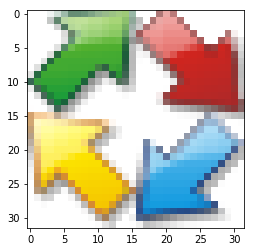

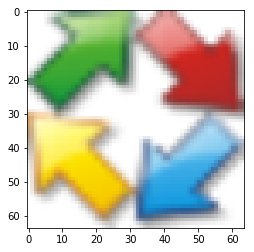

In [4]:
from PIL import Image

im = Image.open("example3232.png")
rescale = transforms.Resize(64)
plt.imshow(im)
plt.show()
plt.imshow(rescale(im))


### Data loading
ref: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887

In [10]:
# Set dataset
patches_notrans = PatchesDataset(data_path='./patches.pkl', transform = transforms.ToTensor())

# Dataloader parameters
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42
loader_notrans = torch.utils.data.DataLoader(patches_notrans, batch_size=batch_size,
                                            num_workers=4)



In [11]:
# Transformations to be compatible with Alexnet.
# Note I am using mean and std as recommended in Pytorch. Maybe calculating the dataset statistics is better.
composed = transforms.Compose([ 
#                                 mm_patch.transforms.ToImage(),
                                transforms.ToTensor(),
                                mm_patch.transforms.Scale(),
#                                 transforms.ToPILImage(),
#                                 transforms.Resize((224,224)),
#                                 transforms.ToTensor(),
                                mm_patch.transforms.GrayToRGB(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

# Set dataset
patches = PatchesDataset(data_path='./patches_224x224.pkl', transform = composed)

# Dataloader parameters
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(patches)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# this train loader is to have random access
loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                            num_workers=4)
train_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4)

### Visualize batch

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


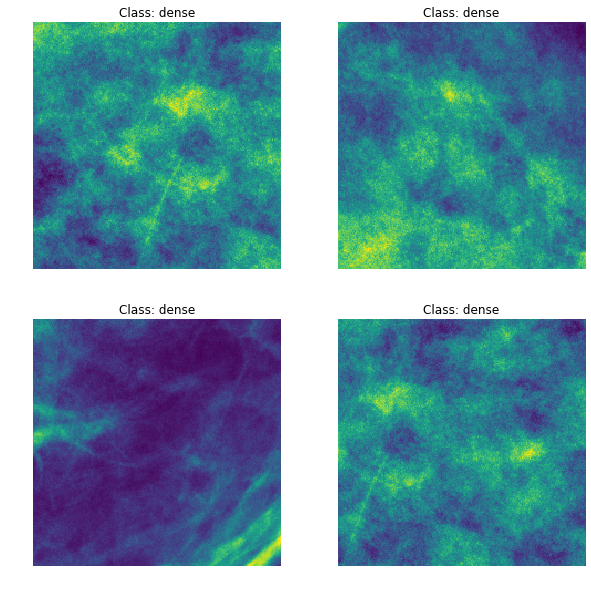

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


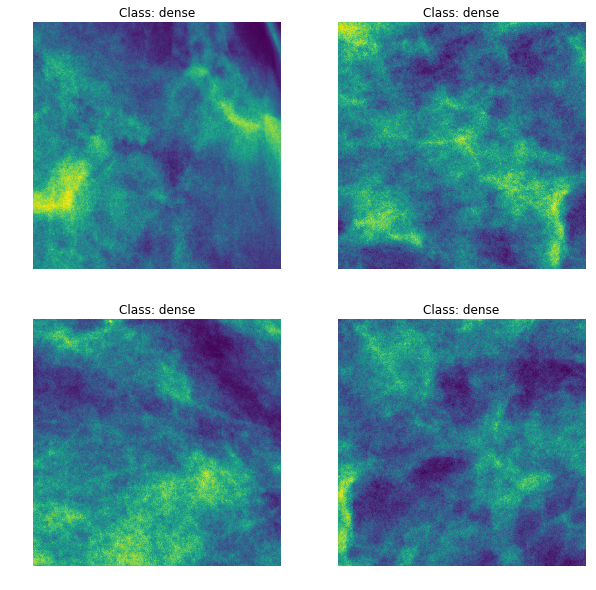

In [12]:
# Helper function to show a batch
def show_patches_batch(sample_batched, max_images = None):
    """Show patches for a batch of samples."""
    patches_batch, targets_batch = \
            sample_batched['patch'], sample_batched['target']
    num_img = len(patches_batch)
    
    if max_images:
        num_img = max_images
    
    sqrt_num_img = np.ceil(np.sqrt(num_img))
    im_size = patches_batch.size(2)
#     print(im_size)
    grid_border_size = 2

    grid = utils.make_grid(patches_batch)
    
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
    fig = plt.figure(figsize = (10,10))
    for i in range(num_img):
        ax = fig.add_subplot(sqrt_num_img, sqrt_num_img, i+1)
        print(patches_batch[i].shape)
        ax.imshow(patches_batch[i][0])
        ax.set_title(f'Class: {patches.unique_labels[targets_batch[i]]}')
        ax.axis('off')
    plt.show()
        
        
batch = next(iter(loader))
batch_notrans = next(iter(loader_notrans))
show_patches_batch(batch)
show_patches_batch(batch_notrans)

### Model

In [13]:
alexnet = models.alexnet(pretrained=True)

In [14]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

### Set up hooks

In [15]:
# get full layer names
alexnet.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [16]:
# get activations
def get_activation(layer_dict, name):
    """
    Define hook to extract intermediate layer features
    """
    def hook(model, input, output):
        layer_dict[name].append(output.detach().view((output.shape[0],-1)))
        # layer_dict[name] = torch.cat(layer_dict[name], output.detach())
    return hook


def save_activations(activations_dict, output_folder):
    """
    Save into separate files activations extracted with a hook. 
    One file per layer/activation.
    :param layer_dict: dictionary with the activations per layer.
    :param output_data_folder: path to folder where to store the activation files.
    """
    
    if os.path.exists(output_folder):
        # Prevent overwriting to an existing directory
        print("Error: the directory to save the activations already exists.")
        return
    else:
        os.makedirs(output_folder)


    for name, activation in activations_dict.items():
        file_path = os.path.join(output_folder,name + '.pkl')
        print(file_path)
        with open(file_path,'wb') as file: 
            np.save(file, activation.numpy())

In [17]:
# register hook
activations = {'avgpool': [], 'linear': []}
handle_avgpool = alexnet.avgpool.register_forward_hook(get_activation(activations, 'avgpool'))
handle_linear = alexnet.classifier[1].register_forward_hook(get_activation(activations, 'linear'))

### Run model

In [19]:
from tqdm import tqdm
with torch.no_grad():
    output = [(alexnet(batch['patch']), batch['target']) for batch in tqdm(loader)]
    # output = [(alexnet(batch['patch']), batch['target']) for batch in train_loader]


100%|██████████| 700/700 [00:41<00:00, 17.03it/s]


In [20]:
features = torch.cat(activations['avgpool'], 0)
linear = torch.cat(activations['linear'], 0)

In [21]:
print(features.shape, linear.shape)

torch.Size([3248, 9216]) torch.Size([3248, 4096])


### Save activations

In [22]:
activations_path = '.'
for name, outputs in activations.items():
        if outputs:
            file_path = os.path.join(activations_path ,name + '.txt')
            with open(file_path,'wb') as file: 
                np.savetxt(file, torch.cat(outputs, 0).numpy())
                outputs = []

### Feature space exploration

#### Nearest Neighbours

In [23]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = features
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices                                           

nn = np.concatenate(indices)


In [25]:
def show_image_index(dataloader, index_ls):
    
    i = 0
    image_ls = [[]]*len(index_ls)
    for batch in dataloader:
        patches_batch, targets_batch = \
            batch['patch'], batch['target']
        num_img = len(patches_batch)

        for idx in range(num_img):
            if i in index_ls:
                ls_idx = np.where(i==index_ls)[0][0]
                image_ls[ls_idx] = patches_batch[idx][0]
            i += 1
    return image_ls

# images = show_image_index(loader, [0,854, 2797, 2793])

images = show_image_index(loader, nn[10:20])


[  5 453 454   6 455   7 456   8   9 457]
10


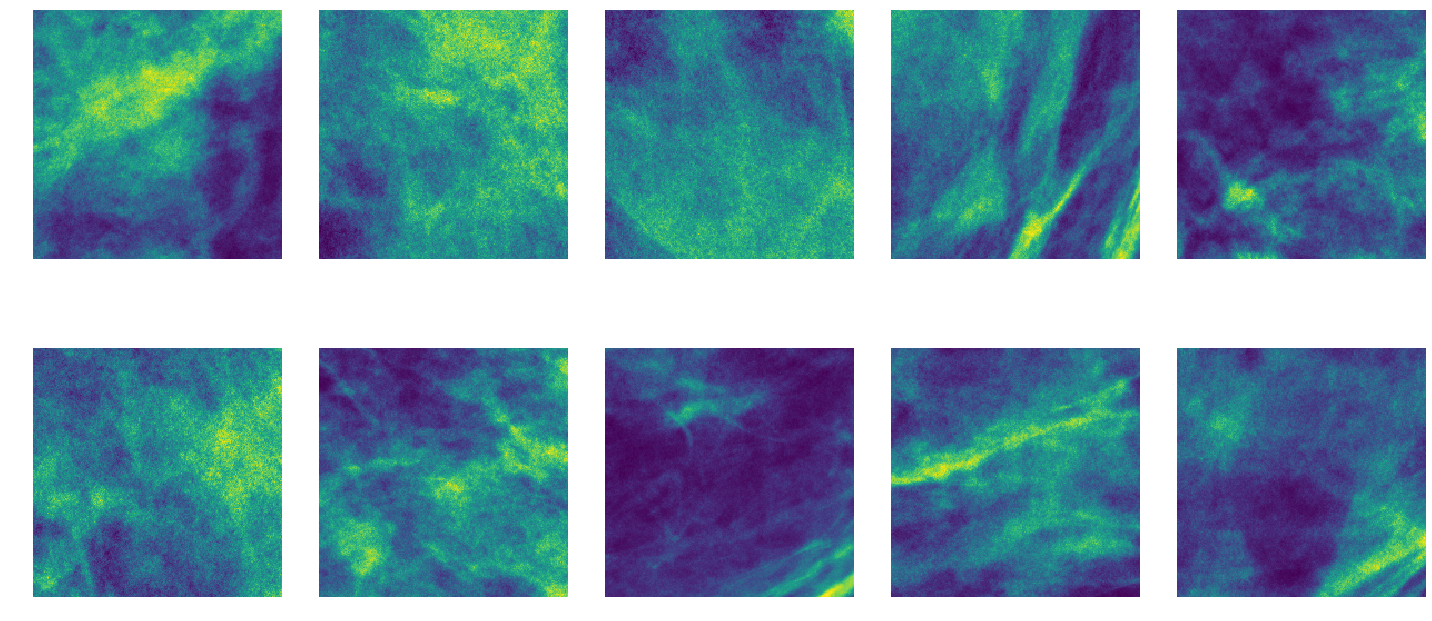

In [26]:
print(nn[10:20])
fig = plt.figure(figsize = (20,10))
num_img = len(images)
print(num_img)
for i in range(0,num_img,2):
    pos_even = int(i/2)+1
    pos_odd = pos_even + int(num_img/2)
    ax = fig.add_subplot(2, num_img/2, pos_even)
    ax.imshow(images[i])
    ax.axis('off')
    ax1 = fig.add_subplot(2, num_img/2, pos_odd)
    ax1.imshow(images[i+1])
    ax1.axis('off')
plt.tight_layout()



### Manual Inspection
Just to verify the previous script

In [ ]:
nn[10:20]

In [ ]:
plt.imshow(patches.data['patch'].iloc[2148])

### PCA

In [27]:
from numpy import linalg as LA
from numpy import cov
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [28]:
# Load activation
with open('activations_alexnet/avgpool.txt') as f:
    features = np.loadtxt(f)

(2800, 9216)
2


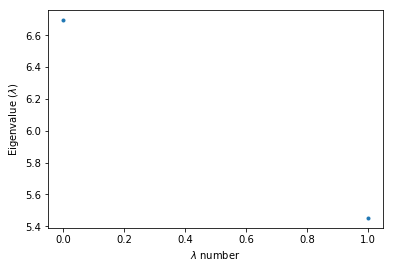

In [29]:
x = linear.numpy()

# define scaler instance
scaler = preprocessing.StandardScaler()

print(features.shape)
# features_ts = scaler.fit_transform(features)
x_centered = x - np.mean(x, axis=0)


# Own implementation (stability error)
# cov_mat = cov(x_centered.T)
# print(cov_mat.shape)

# # Calculate Eigenvectors and Eigenvalues
# w, v = LA.eig(cov_mat)
# print("w:", w)
# # print("v:", v)



# Using scipy package

# percentage of variance explained
# can also use: PCA(n_components=2)
pca = PCA(n_components=2)
x_centered = pca.fit_transform(x_centered)
# pca.explained_variance_ are the eigenvalues
eigenvalues = pca.explained_variance_ 
print(len(eigenvalues))
# pca.components_ are the eigenvectors
# print(pca.components_[1,:])


# Plot eigenvalues 
plt.plot(np.log(eigenvalues), '.')
plt.ylabel('Eigenvalue $(\lambda)$')
plt.xlabel('$\lambda$ number')
plt.show()

(3248, 2)

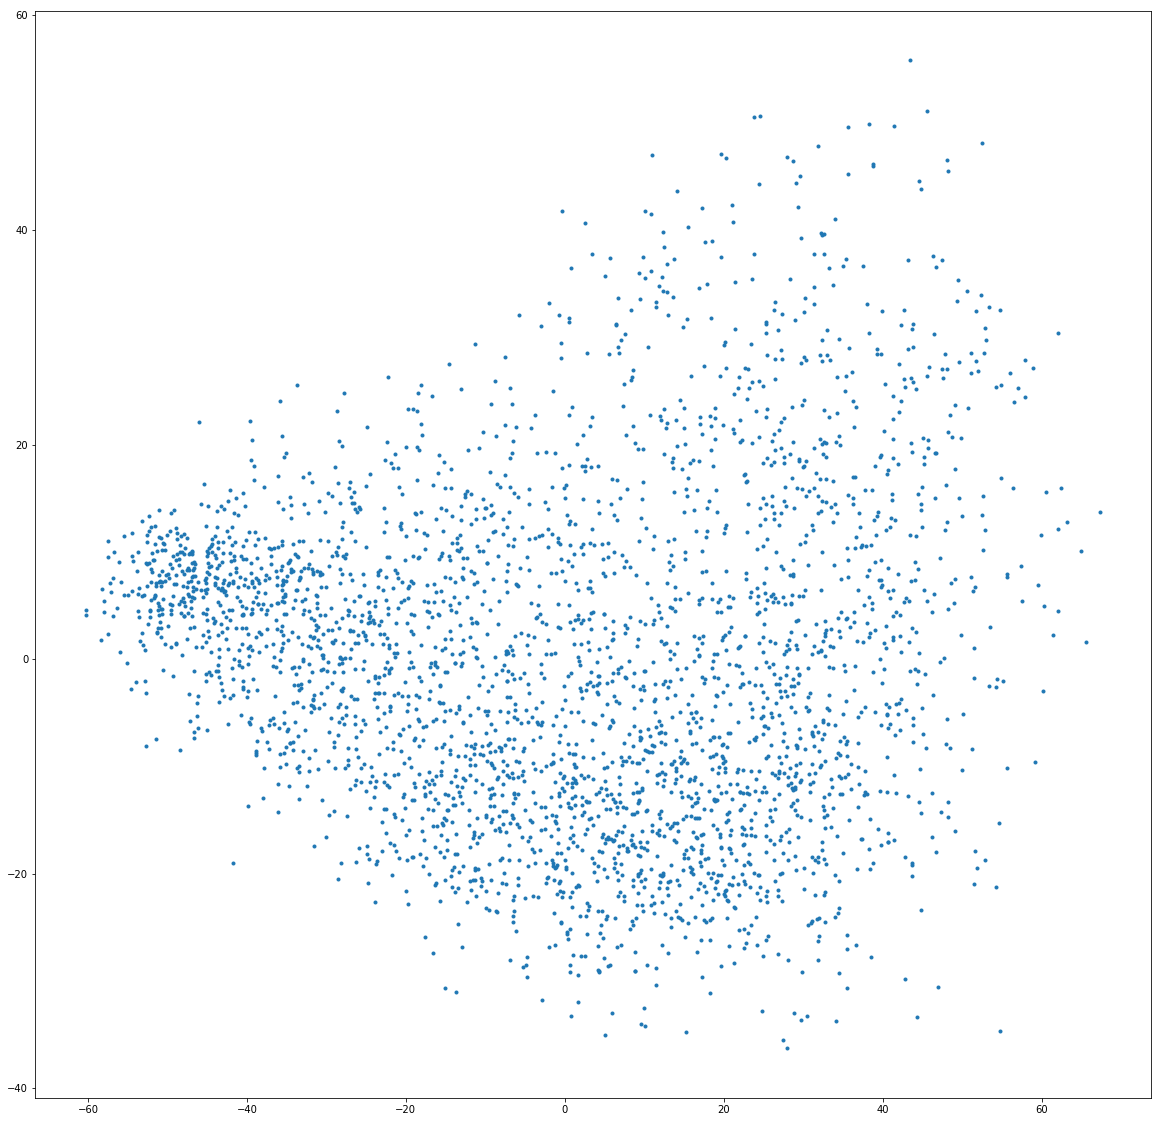

In [30]:
fig = plt.figure(figsize = (20,20))
plt.plot(x_centered[:,0],x_centered[:,1], '.')
x_centered.shape

### ID

`id2nn` is my implementation, `id2nnal` is Alessio's implementation. There is a slight difference in the ID estimation. The overall behaviour is the same. There is a *good* parameter in Alessio's code that I could check. Also maybe cumsum is different?

`id2nn` was showing the same results as Elena Facco's implementation.

In [31]:
import sys
sys.path.insert(0,'/home/fede/Documents/mhpc/mhpc-thesis/code/TWO-NN')
import id2nn

  0%|          | 3/2800 [00:00<01:46, 26.31it/s]

Start shuffle..
Finished shuffle
Start dist_mat


  0%|          | 0/20 [00:00<?, ?it/s]

Finished dist_mat


100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


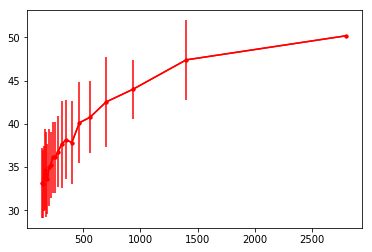

In [32]:
# Load activation
with open('activations_alexnet/linear.txt') as f:
    features = np.loadtxt(f)

np.random.seed(10)

# dim, mu, mu_cs = two_nn_id(data, 0.9)

blocks_dim, blocks_dim_std, blocks_size, d_mat2 = id2nn.two_nn_block_analysis(features, .9, shuffle = True)

# print(len(blocks_dim))
# # print(len(blocks_dim_std))

file_path = './activations_alexnet/block_analysis_linear.txt'
with open(file_path, 'wb') as file: 
    np.savetxt(file, np.array(blocks_dim))
    np.savetxt(file, np.array(blocks_dim_std))


plt.plot(blocks_size, blocks_dim, "r.-")
plt.errorbar(blocks_size, blocks_dim, fmt = "r.-", yerr = np.array(blocks_dim_std))
plt.show()

In [ ]:
import id2nnal

In [ ]:
features.dtype

In [ ]:
d_mat = np.sqrt(d_mat2)
np.fill_diagonal(d_mat, 0)

In [ ]:
dim, std, points = id2nnal.block_analysis(d_mat, blocks=list(range(1, 21)), fraction=0.9)

In [ ]:
plt.errorbar(points, dim, fmt = "r.-", yerr = std)
plt.show()


In [ ]:
dim[0], blocks_dim[0]